# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [17]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.8.0+cpu


# Preparing Training and Test Sets

In [33]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
# Map our class names to the actual dataset folder names
source_map = {
    'normal': 'Normal',
    'viral': 'Viral Pneumonia',
    'covid': 'COVID'
}

# Create a small test split if it doesn't exist
import os
import shutil
import random

# We won't rename dataset folders; instead, we will sample from the existing folders
if not os.path.isdir(os.path.join(root_dir, 'test')):
    os.makedirs(os.path.join(root_dir, 'test'), exist_ok=True)
    for c in class_names:
        os.makedirs(os.path.join(root_dir, 'test', c), exist_ok=True)

    # For each class, pick up to 30 images from the class images directory and MOVE them to test split
    for c in class_names:
        # Determine where the images live: either directly in the class dir or in a nested 'images' dir
        base_dir = os.path.join(root_dir, source_map[c])
        images_dir = os.path.join(base_dir, 'images')
        src_dir = images_dir if os.path.isdir(images_dir) else base_dir

        if not os.path.isdir(src_dir):
            print(f"Warning: source directory not found for class '{c}': {src_dir}")
            continue

        images = [x for x in os.listdir(src_dir) if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not images:
            print(f"Warning: no images found for class '{c}' in {src_dir}")
            continue

        k = min(30, len(images))
        selected_images = random.sample(images, k)
        for image in selected_images:
            source_path = os.path.join(src_dir, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            # Move into test split
            shutil.move(source_path, target_path)

    print("Test split prepared at 'COVID-19 Radiography Database/test'.")
else:
    print("Test split already exists. Skipping preparation.")

Test split already exists. Skipping preparation.


# Creating Custom Dataset

In [49]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, index=None):
        def list_images_for_class(dir_path):
            # Support when a nested images folder is passed
            if os.path.isdir(os.path.join(dir_path, 'images')):
                dir_path = os.path.join(dir_path, 'images')
            if not os.path.isdir(dir_path):
                raise FileNotFoundError(f"Directory not found: {dir_path}")
            images = [x for x in os.listdir(dir_path) if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
            return dir_path, images
        
        self.class_names = ['normal', 'viral', 'covid']
        self.image_dirs = image_dirs
        self.transform = transform

        # Build per-class image lists from folders
        self.images = {}
        for class_name in self.class_names:
            dir_path, imgs = list_images_for_class(image_dirs[class_name])
            self.images[class_name] = {'dir': dir_path, 'files': imgs}
            print(f"Found {len(imgs)} {class_name} examples in {dir_path}")

        # Build a flat deterministic index of (class_name, file_name)
        if index is not None:
            self.index = index
        else:
            self.index = []
            for class_name in self.class_names:
                for fname in self.images[class_name]['files']:
                    self.index.append((class_name, fname))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        class_name, file_name = self.index[idx]
        dir_path = self.images[class_name]['dir']
        image_path = os.path.join(dir_path, file_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [35]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [50]:
from collections import defaultdict

train_dirs = {
    'normal': 'COVID-19 Radiography Database/Normal',
    'viral': 'COVID-19 Radiography Database/Viral Pneumonia',
    'covid': 'COVID-19 Radiography Database/COVID'
}

# Build full index from folders, then split to train/val stratified per class
_tmp = ChestXRayDataset(train_dirs, train_transform)
per_class_files = defaultdict(list)
for class_name in _tmp.class_names:
    for fname in _tmp.images[class_name]['files']:
        per_class_files[class_name].append(fname)

random.seed(42)
val_fraction = 0.2
train_index, val_index = [], []
for class_name, files in per_class_files.items():
    random.shuffle(files)
    split = int(len(files) * (1 - val_fraction))
    train_files = files[:split]
    val_files = files[split:]
    train_index.extend([(class_name, f) for f in train_files])
    val_index.extend([(class_name, f) for f in val_files])

# Rebuild datasets with deterministic indices
train_dataset = ChestXRayDataset(train_dirs, train_transform, index=train_index)
val_dataset = ChestXRayDataset(train_dirs, test_transform, index=val_index)


Found 10162 normal examples in COVID-19 Radiography Database/Normal\images
Found 1315 viral examples in COVID-19 Radiography Database/Viral Pneumonia\images
Found 3586 covid examples in COVID-19 Radiography Database/COVID\images
Found 10162 normal examples in COVID-19 Radiography Database/Normal\images
Found 1315 viral examples in COVID-19 Radiography Database/Viral Pneumonia\images
Found 3586 covid examples in COVID-19 Radiography Database/COVID\images
Found 10162 normal examples in COVID-19 Radiography Database/Normal\images
Found 1315 viral examples in COVID-19 Radiography Database/Viral Pneumonia\images
Found 3586 covid examples in COVID-19 Radiography Database/COVID\images


In [37]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

# Ensure the test class folders exist
for c in ['normal', 'viral', 'covid']:
    os.makedirs(os.path.join('COVID-19 Radiography Database', 'test', c), exist_ok=True)

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples in COVID-19 Radiography Database/test/normal
Found 30 viral examples in COVID-19 Radiography Database/test/viral
Found 30 covid examples in COVID-19 Radiography Database/test/covid


In [ ]:
batch_size = 32
num_workers = 0  # set 0 in notebooks on Windows to avoid hangs
pin = torch.cuda.is_available()

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=num_workers, pin_memory=pin, persistent_workers=False)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                     num_workers=num_workers, pin_memory=pin, persistent_workers=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=num_workers, pin_memory=pin, persistent_workers=False)

print('Number of training batches', len(dl_train))
print('Number of validation batches', len(dl_val))
print('Number of test batches', len(dl_test))

Number of training batches 377
Number of validation batches 95
Number of test batches 3


# Data Visualization

In [39]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

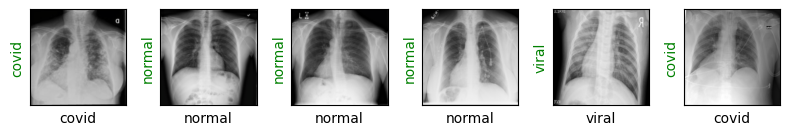

In [40]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

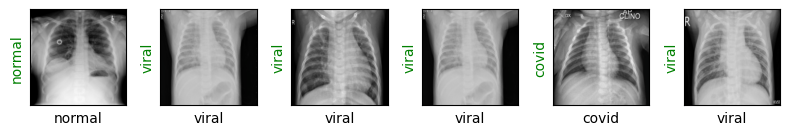

In [41]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [52]:
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights).to(device)

print(resnet18)
print('Using device:', device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    with torch.no_grad():
        images, labels = next(iter(dl_test))
        images = images.to(device, non_blocking=True)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        # Move to CPU for visualization
        show_images(images.cpu(), labels, preds.cpu())

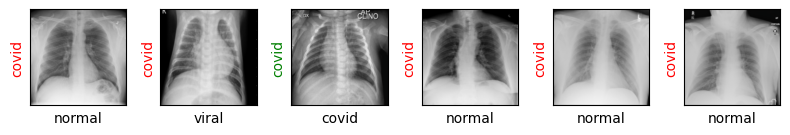

In [45]:
show_preds()

# Training the Model

In [ ]:
from torch.amp import autocast, GradScaler

scaler = GradScaler(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=torch.cuda.is_available())

def evaluate(loader):
    resnet18.eval()
    total, correct, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=torch.cuda.is_available()):
                outputs = resnet18(images)
                loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return val_loss / max(1, len(loader)), correct / max(1, total)


def train(epochs, patience=2, max_steps_per_epoch=200, val_every=200):
    print('Starting training..')
    best_acc = 0.0
    best_state = None
    bad_epochs = 0
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        resnet18.train()
        running_loss = 0.0

        for step, (images, labels) in enumerate(dl_train):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', enabled=torch.cuda.is_available()):
                outputs = resnet18(images)
                loss = loss_fn(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (step % val_every) == 0:
                val_loss, val_acc = evaluate(dl_val)
                print(f"Step {step}: train_loss={running_loss / max(1, step+1):.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")
                resnet18.train()

            if step + 1 >= max_steps_per_epoch:
                break

        train_loss = running_loss / max(1, min(len(dl_train), max_steps_per_epoch))
        val_loss, val_acc = evaluate(dl_val)
        print(f"Epoch {e+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {
                'model': resnet18.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': e+1,
                'val_acc': best_acc,
            }
            torch.save(best_state, 'best_resnet18_cxr.pt')
            bad_epochs = 0
            print('Saved new best checkpoint.')
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print('Early stopping triggered.')
                break

    print('Training complete.')
    if best_state is not None:
        resnet18.load_state_dict(best_state['model'])
        print(f"Loaded best model with val_acc={best_state['val_acc']:.4f}")

C:\Users\User\AppData\Local\Temp\ipykernel_23424\2283060834.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [1]:
%%time

train(epochs=1)

CPU times: total: 0 ns
Wall time: 6.68 μs


NameError: name 'train' is not defined

# Final Results

In [ ]:
show_preds()